Wildlife Poaching Prevention - POP Execution
Planning Successful! Displaying POP Graph...



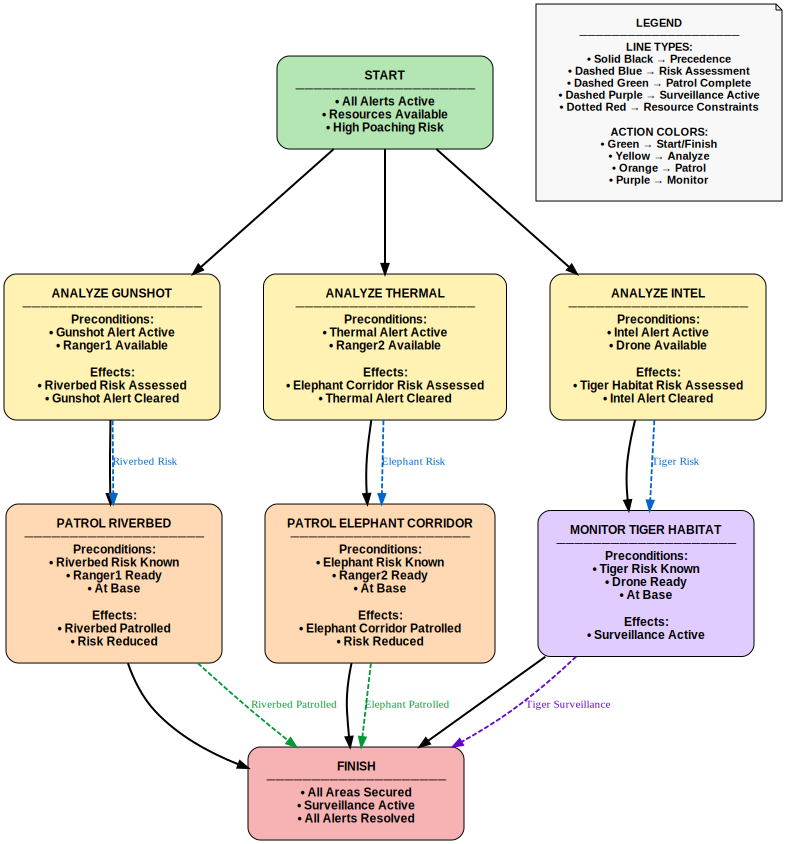

Graph saved as wildlife_pop_graph.png


In [4]:
import graphviz
from graphviz import Digraph
from collections import deque

class PartialOrderPlanner:
    def __init__(self, operators, initial_state, goal_state):
        self.operators = operators
        self.initial_state = set(initial_state)
        self.goal_state = set(goal_state)

    def make_minimal_plan(self):
        plan = {
            'steps': {'Start': {'type': 'initial', 'effects': self.initial_state},
                      'Finish': {'type': 'goal', 'preconditions': self.goal_state}},
            'orderings': [('Start', 'Finish')],
            'links': [],
            'open_preconditions': []
        }
        for goal in self.goal_state:
            plan['open_preconditions'].append(('Finish', goal))

        return plan

    def get_effects(self, step, plan):
        if step == 'Start':
            return self.initial_state
        elif step == 'Finish':
            return set()
        else:
            return set(self.operators[step]['effects'])

    def select_subgoal(self, plan):
        if plan['open_preconditions']:
            return plan['open_preconditions'][0]
        return None

    def choose_operator(self, plan, step, precondition):
        if precondition in self.initial_state:
            plan['links'].append(('Start', precondition, step))
            return True
        if precondition.startswith('NOT('):
            negated = precondition[4:-1]
            if negated not in self.initial_state:
                plan['links'].append(('Start', precondition, step))
                return True
        for existing_step in plan['steps']:
            if existing_step != step:
                effects = self.get_effects(existing_step, plan)
                if precondition in effects:
                    plan['links'].append((existing_step, precondition, step))
                    if (existing_step, step) not in plan['orderings']:
                        plan['orderings'].append((existing_step, step))
                    return True
        for op_name, op_details in self.operators.items():
            if op_name in plan['steps']:
                continue

            effects = op_details['effects']
            if precondition in effects:
                plan['steps'][op_name] = op_details
                plan['links'].append((op_name, precondition, step))
                plan['orderings'].append(('Start', op_name))
                plan['orderings'].append((op_name, step))
                plan['orderings'].append((op_name, 'Finish'))

                for precond in op_details['preconditions']:
                    plan['open_preconditions'].append((op_name, precond))

                return True

        return False

    def resolve_threats(self, plan):
        for link in plan['links']:
            producer, condition, consumer = link

            for threat_step in plan['steps']:
                if threat_step in [producer, consumer, 'Start', 'Finish']:
                    continue

                effects = self.get_effects(threat_step, plan)
                is_threat = False
                if condition.startswith('NOT('):
                    pos_condition = condition[4:-1]
                    if pos_condition in effects:
                        is_threat = True
                else:
                    neg_condition = f"NOT({condition})"
                    if neg_condition in effects:
                        is_threat = True

                if is_threat:
                    if (threat_step, producer) not in plan['orderings']:
                        plan['orderings'].append((threat_step, producer))
                        if self.is_consistent(plan):
                            continue
                        else:
                            plan['orderings'].remove((threat_step, producer))

                    if (consumer, threat_step) not in plan['orderings']:
                        plan['orderings'].append((consumer, threat_step))
                        if self.is_consistent(plan):
                            continue
                        else:
                            plan['orderings'].remove((consumer, threat_step))

        return True

    def is_consistent(self, plan):
        graph = {step: [] for step in plan['steps']}
        for before, after in plan['orderings']:
            graph[before].append(after)

        visited = set()
        recursion_stack = set()

        def has_cycle(node):
            visited.add(node)
            recursion_stack.add(node)
            for neighbor in graph[node]:
                if neighbor not in visited:
                    if has_cycle(neighbor):
                        return True
                elif neighbor in recursion_stack:
                    return True
            recursion_stack.remove(node)
            return False

        for node in graph:
            if node not in visited:
                if has_cycle(node):
                    return False
        return True

    def solution(self, plan):
        return len(plan['open_preconditions']) == 0

    def solve(self):
        plan = self.make_minimal_plan()
        iteration = 0
        max_iterations = 100
        while iteration < max_iterations and not self.solution(plan):
            subgoal = self.select_subgoal(plan)
            if not subgoal:
                break
            step, precondition = subgoal
            if not self.choose_operator(plan, step, precondition):
                return None
            plan['open_preconditions'].remove((step, precondition))
            if not self.resolve_threats(plan):
                return None
            iteration += 1
        if self.solution(plan):
            return plan
        else:
            return None

def create_wildlife_problem():
    operators = {
        'Analyze_Gunshot': {
            'preconditions': {'AlertActive(Gunshot)', 'ResourceAvailable(Ranger1)'},
            'effects': {'RiskAssessed(Riverbed)', 'NOT(AlertActive(Gunshot))'}
        },
        'Analyze_Thermal': {
            'preconditions': {'AlertActive(Thermal)', 'ResourceAvailable(Ranger2)'},
            'effects': {'RiskAssessed(ElephantCorridor)', 'NOT(AlertActive(Thermal))'}
        },
        'Analyze_Intel': {
            'preconditions': {'AlertActive(Intel)', 'ResourceAvailable(Drone)'},
            'effects': {'RiskAssessed(TigerHabitat)', 'NOT(AlertActive(Intel))'}
        },
        'Patrol_Riverbed': {
            'preconditions': {'RiskAssessed(Riverbed)', 'ResourceAvailable(Ranger1)', 'At(Ranger1, Base)'},
            'effects': {'Patrolled(Riverbed)', 'NOT(PoachingRisk(Riverbed, High))'}
        },
        'Patrol_ElephantCorridor': {
            'preconditions': {'RiskAssessed(ElephantCorridor)', 'ResourceAvailable(Ranger2)', 'At(Ranger2, Base)'},
            'effects': {'Patrolled(ElephantCorridor)', 'NOT(PoachingRisk(ElephantCorridor, High))'}
        },
        'Monitor_TigerHabitat': {
            'preconditions': {'RiskAssessed(TigerHabitat)', 'ResourceAvailable(Drone)', 'At(Drone, Base)'},
            'effects': {'SurveillanceActive(TigerHabitat)'}
        }
    }

    initial_state = {
        'At(Ranger1, Base)', 'At(Ranger2, Base)', 'At(Drone, Base)',
        'ResourceAvailable(Ranger1)', 'ResourceAvailable(Ranger2)', 'ResourceAvailable(Drone)',
        'AlertActive(Gunshot)', 'AlertActive(Thermal)', 'AlertActive(Intel)',
        'PoachingRisk(Riverbed, High)', 'PoachingRisk(ElephantCorridor, High)', 'PoachingRisk(TigerHabitat, High)'
    }

    goal_state = {
        'Patrolled(Riverbed)', 'Patrolled(ElephantCorridor)', 'SurveillanceActive(TigerHabitat)',
        'NOT(AlertActive(Gunshot))', 'NOT(AlertActive(Thermal))', 'NOT(AlertActive(Intel))'
    }

    return operators, initial_state, goal_state

def create_clear_pop_graph():
    dot = Digraph(
        comment="Wildlife Poaching POP Plan",
        graph_attr={
            'rankdir': 'TB',
            'fontsize': '16',
            'splines': 'true',
            'nodesep': '0.6',
            'ranksep': '1.0',
            'fontname': 'Helvetica'
        },
        node_attr={
            'shape': 'rect',
            'style': 'filled,rounded',
            'fontname': 'Helvetica-Bold',
            'fontsize': '12',
            'margin': '0.3,0.2',
            'width': '2.5'
        }
    )

    colors = {
        'start': '#b3e6b3',
        'goal': '#f7b3b3',
        'analysis': '#fff2b2',
        'patrol': '#ffd9b3',
        'monitor': '#e0ccff'
    }

    dot.node('Start',
             'START\n────────────────────\n• All Alerts Active\n• Resources Available\n• High Poaching Risk',
             fillcolor=colors['start'], width='3')

    dot.node('A1',
             'ANALYZE GUNSHOT\n────────────────────\nPreconditions:\n• Gunshot Alert Active\n• Ranger1 Available\n\nEffects:\n• Riverbed Risk Assessed\n• Gunshot Alert Cleared',
             fillcolor=colors['analysis'], width='3')
    dot.node('A2',
             'ANALYZE THERMAL\n────────────────────\nPreconditions:\n• Thermal Alert Active\n• Ranger2 Available\n\nEffects:\n• Elephant Corridor Risk Assessed\n• Thermal Alert Cleared',
             fillcolor=colors['analysis'], width='3')
    dot.node('A3',
             'ANALYZE INTEL\n────────────────────\nPreconditions:\n• Intel Alert Active\n• Drone Available\n\nEffects:\n• Tiger Habitat Risk Assessed\n• Intel Alert Cleared',
             fillcolor=colors['analysis'], width='3')

    dot.node('P1',
             'PATROL RIVERBED\n────────────────────\nPreconditions:\n• Riverbed Risk Known\n• Ranger1 Ready\n• At Base\n\nEffects:\n• Riverbed Patrolled\n• Risk Reduced',
             fillcolor=colors['patrol'], width='3')
    dot.node('P2',
             'PATROL ELEPHANT CORRIDOR\n────────────────────\nPreconditions:\n• Elephant Risk Known\n• Ranger2 Ready\n• At Base\n\nEffects:\n• Elephant Corridor Patrolled\n• Risk Reduced',
             fillcolor=colors['patrol'], width='3')

    dot.node('M1',
             'MONITOR TIGER HABITAT\n────────────────────\nPreconditions:\n• Tiger Risk Known\n• Drone Ready\n• At Base\n\nEffects:\n• Surveillance Active',
             fillcolor=colors['monitor'], width='3')

    dot.node('Finish',
             'FINISH\n────────────────────\n• All Areas Secured\n• Surveillance Active\n• All Alerts Resolved',
             fillcolor=colors['goal'], width='3')

    precedence = [
        ('Start', 'A1'), ('Start', 'A2'), ('Start', 'A3'),
        ('A1', 'P1'), ('A2', 'P2'), ('A3', 'M1'),
        ('P1', 'Finish'), ('P2', 'Finish'), ('M1', 'Finish')
    ]
    for s, t in precedence:
        dot.edge(s, t, color='black', penwidth='2.0')

    causal = [
        ('A1', 'P1', 'Riverbed Risk', '#0066CC'),
        ('A2', 'P2', 'Elephant Risk', '#0066CC'),
        ('A3', 'M1', 'Tiger Risk', '#0066CC'),
        ('P1', 'Finish', 'Riverbed Patrolled', '#009933'),
        ('P2', 'Finish', 'Elephant Patrolled', '#009933'),
        ('M1', 'Finish', 'Tiger Surveillance', '#6600CC')
    ]
    for s, t, lbl, col in causal:
        dot.edge(s, t, label=lbl, color=col, fontcolor=col,
                 style='dashed', penwidth='1.8', fontsize='11')

    legend = '''LEGEND
────────────────────
LINE TYPES:
• Solid Black → Precedence
• Dashed Blue → Risk Assessment
• Dashed Green → Patrol Complete
• Dashed Purple → Surveillance Active
• Dotted Red → Resource Constraints

ACTION COLORS:
• Green → Start/Finish
• Yellow → Analyze
• Orange → Patrol
• Purple → Monitor'''
    dot.node('Legend', legend,
             shape='note', fillcolor='#f8f8f8', fontsize='11', width='2.8')

    return dot

def main():
    print("Wildlife Poaching Prevention - POP Execution\n" + "="*60)
    operators, initial_state, goal_state = create_wildlife_problem()
    planner = PartialOrderPlanner(operators, initial_state, goal_state)
    solution = planner.solve()

    if solution:
        print("Planning Successful! Displaying POP Graph...\n")
        graph = create_clear_pop_graph()
        display(graph)
        graph.render("wildlife_pop_graph", format="png", cleanup=True)
        print("Graph saved as wildlife_pop_graph.png")
    else:
        print("Planning Failed")


if __name__ == "__main__":
    main()


In [9]:
from dataclasses import dataclass
from typing import Set, Tuple, Dict, List, Optional
import itertools
import matplotlib.pyplot as plt
import networkx as nx

def is_neg(lit: str) -> bool:
    return lit.startswith("¬")

def negate(lit: str) -> str:
    return lit[1:] if is_neg(lit) else f"¬{lit}"
@dataclass(frozen=True)

class Action:
    name: str
    pre: Tuple[str, ...]
    add: Tuple[str, ...]
    rem: Tuple[str, ...]
    def produces(self) -> Set[str]:
        return set(self.add)

    def requires(self) -> Set[str]:
        return set(self.pre)

domain_actions: List[Action] = [
    Action("Analyze_Gunshot", pre=("Alert(GunshotRiverbed)",),
           add=("RiskAssessed(Riverbed)", "AlertCleared(GunshotRiverbed)"),
           rem=("¬Alert(GunshotRiverbed)",)),
    Action("Analyze_Thermal", pre=("Alert(ThermalEleCorridor)",),
           add=("RiskAssessed(ElephantCorridor)", "AlertCleared(ThermalEleCorridor)"),
           rem=("¬Alert(ThermalEleCorridor)",)),
    Action("Analyze_Intel", pre=("Alert(IntelTigerHabitat)",),
           add=("RiskAssessed(TigerHabitat)", "AlertCleared(IntelTigerHabitat)"),
           rem=("¬Alert(IntelTigerHabitat)",)),
    Action("Assign_Ranger1_Riverbed", pre=("RiskAssessed(Riverbed)", "Free(Ranger1)"),
           add=("Assigned(Ranger1,Riverbed)", "Engaged(Ranger1)"),
           rem=("¬Free(Ranger1)",)),
    Action("Dispatch_Ranger1_Riverbed", pre=("Assigned(Ranger1,Riverbed)",),
           add=("Patrolled(Riverbed)",), rem=()),

    Action("Assign_Ranger2_ECorridor", pre=("RiskAssessed(ElephantCorridor)", "Free(Ranger2)"),
           add=("Assigned(Ranger2,EleCorridor)", "Engaged(Ranger2)"),
           rem=("¬Free(Ranger2)",)),
    Action("Dispatch_Ranger2_ECorridor", pre=("Assigned(Ranger2,EleCorridor)",),
           add=("Patrolled(ElephantCorridor)",), rem=()),
    Action("Monitor_Tiger_Drone", pre=("RiskAssessed(TigerHabitat)", "Free(Drone)"),
           add=("SurveillanceActive(TigerHabitat)", "Engaged(Drone)"),
           rem=("¬Free(Drone)",)),
]
S0: Set[str] = {
    "Alert(GunshotRiverbed)",
    "Alert(ThermalEleCorridor)",
    "Alert(IntelTigerHabitat)",
    "Free(Ranger1)", "Free(Ranger2)", "Free(Drone)"
}
GOALS: Set[str] = {
    "Patrolled(Riverbed)",
    "Patrolled(ElephantCorridor)",
    "SurveillanceActive(TigerHabitat)",
    "AlertCleared(GunshotRiverbed)",
    "AlertCleared(ThermalEleCorridor)",
    "AlertCleared(IntelTigerHabitat)",
}
class PlanningGraph:
    def __init__(self, actions: List[Action], initial: Set[str]):
        self.actions = actions
        self.S_levels: List[Set[str]] = [set(initial)]
        self.A_levels: List[Set[Action]] = []
        self.S_mutex: List[Set[Tuple[str, str]]] = []
        self.A_mutex: List[Set[Tuple[str, str]]] = []

    def noops_for(self, literals: Set[str]) -> List[Action]:
        noops = []
        for lit in literals:
            noops.append(Action(f"NOOP_{lit}", pre=(lit,), add=(lit,), rem=()))
        return noops

    def build_until(self, goals: Set[str], max_levels: int = 8) -> bool:
        leveled_off = False
        k = 0
        while not leveled_off and k < max_levels:
            current_S = self.S_levels[k]
            applicable = {a for a in self.actions if set(a.pre).issubset(current_S)}
            applicable.update(self.noops_for(current_S))
            self.A_levels.append(applicable)
            self.A_mutex.append(self.compute_a_mutex(applicable, self.S_levels[k]))
            next_S = set(current_S)
            for a in applicable:
                next_S.update(a.add)
            self.S_levels.append(next_S)
            self.S_mutex.append(self.compute_s_mutex(self.A_levels[k], self.A_mutex[k]))
            if self.S_levels[k+1] == self.S_levels[k]:
                leveled_off = True
            if goals.issubset(self.S_levels[k+1]) and self.goals_non_mutex(goals, k+1):
                return True
            k += 1
        return False

    def goals_non_mutex(self, goals: Set[str], s_level: int) -> bool:
        mutex = self.S_mutex[s_level-1] if s_level-1 < len(self.S_mutex) else set()
        for g1, g2 in itertools.combinations(goals, 2):
            if (g1, g2) in mutex or (g2, g1) in mutex:
                return False
        return True

    def compute_a_mutex(self, actions: Set[Action], prev_S: Set[str]) -> Set[Tuple[str, str]]:
        mutex_pairs = set()
        for a1, a2 in itertools.combinations(actions, 2):
            if self.inconsistent_effects(a1, a2) or self.interference(a1, a2) or self.competing_needs(a1, a2, prev_S):
                mutex_pairs.add((a1.name, a2.name))
        return mutex_pairs

    def inconsistent_effects(self, a1: Action, a2: Action) -> bool:
        adds1, adds2 = set(a1.add), set(a2.add)
        return any(negate(x) in adds2 for x in adds1) or any(negate(x) in adds1 for x in adds2)

    def interference(self, a1: Action, a2: Action) -> bool:
        if any(negate(p) in a1.add or negate(p) in a1.rem for p in a2.pre):
            return True
        if any(negate(p) in a2.add or negate(p) in a2.rem for p in a1.pre):
            return True
        return False

    def competing_needs(self, a1: Action, a2: Action, prev_S: Set[str]) -> bool:
        for p1 in a1.pre:
            for p2 in a2.pre:
                if negate(p1) == p2 or negate(p2) == p1:
                    return True
        return False

    def compute_s_mutex(self, A_level: Set[Action], A_mutex_pairs: Set[Tuple[str, str]]) -> Set[Tuple[str, str]]:
        literals = set()
        for a in A_level:
            literals.update(a.add)
        mutex = set()
        for p, q in itertools.combinations(literals, 2):
            if negate(p) == q or negate(q) == p:
                mutex.add((p, q))
        supporters: Dict[str, Set[str]] = {}
        for a in A_level:
            for eff in a.add:
                supporters.setdefault(eff, set()).add(a.name)

        for p, q in itertools.combinations(literals, 2):
            if (p, q) in mutex or (q, p) in mutex:
                continue
            supp_p = supporters.get(p, set())
            supp_q = supporters.get(q, set())
            if supp_p and supp_q:
                all_mutex = True
                for sp in supp_p:
                    for sq in supp_q:
                        if (sp, sq) not in A_mutex_pairs and (sq, sp) not in A_mutex_pairs:
                            all_mutex = False
                            break
                    if not all_mutex:
                        break
                if all_mutex:
                    mutex.add((p, q))
        return mutex
def extract_plan(pg: PlanningGraph, goals: Set[str]) -> Optional[List[Action]]:
    last_level = len(pg.S_levels) - 1
    while last_level > 0 and not (goals.issubset(pg.S_levels[last_level]) and pg.goals_non_mutex(goals, last_level)):
        last_level -= 1
    if last_level == 0:
        return None

    plan: List[Action] = []

    def dfs(level: int, subgoals: Set[str], chosen: List[Action]) -> Optional[List[Action]]:
        if level == 0:
            return list(reversed(chosen))
        needed = list(subgoals)
        producers: Dict[str, List[Action]] = {}
        for g in needed:
            producers[g] = [a for a in pg.A_levels[level-1] if g in a.add]
        order = sorted(needed, key=lambda g: len(producers[g]))
        def backtrack(i: int, chosen_set: List[Action], new_goals: Set[str]) -> Optional[List[Action]]:
            if i == len(order):
                return dfs(level-1, new_goals, chosen_set + chosen)
            g = order[i]
            for a in producers[g]:
                mutex_pairs = pg.A_mutex[level-1]
                ok = True
                for c in chosen_set:
                    if (a.name, c.name) in mutex_pairs or (c.name, a.name) in mutex_pairs:
                        ok = False
                        break
                if not ok:
                    continue
                ng = set(new_goals)
                ng.update(a.pre)
                return_val = backtrack(i+1, chosen_set+[a], ng)
                if return_val is not None:
                    return return_val
            return None
        return backtrack(0, [], set())

    return dfs(last_level, goals, [])
pg = PlanningGraph(domain_actions, S0)
reachable = pg.build_until(GOALS, max_levels=8)
plan = extract_plan(pg, GOALS)

print("Goals reachable:", reachable)
print("\n--- Extracted Plan (GraphPlan) ---")
if plan:
    for i, a in enumerate(plan, 1):
        print(f"{i}. {a.name}  Pre={list(a.pre)}  Add={list(a.add)}")
else:
    print("No plan found.")
def visualize_graphplan_clean(pg, filename="graphplan_clean"):
    """Generate a clear, layered GraphPlan visualization using Graphviz"""
    dot = Digraph(comment="GraphPlan - Wildlife Poaching Prevention")
    dot.attr(rankdir='LR', fontsize='12', nodesep='0.6', ranksep='1.0')
    color_state = "#E6F2FF"
    color_action = "#FFD580"
    color_mutex = "#FFB3B3"
    for k, S in enumerate(pg.S_levels):
        with dot.subgraph(name=f"cluster_S{k}") as s_cluster:
            s_cluster.attr(label=f"STATE LEVEL S{k}", color="blue", style="dashed", fontsize="12")
            for lit in sorted(S):
                s_cluster.node(f"S{k}_{lit}", label=lit, shape="box", style="filled,rounded",
                               fillcolor=color_state, fontsize="10", width="2.5")

        if k < len(pg.A_levels):
            with dot.subgraph(name=f"cluster_A{k}") as a_cluster:
                a_cluster.attr(label=f"ACTION LEVEL A{k}", color="orange", style="dashed", fontsize="12")
                for a in sorted(pg.A_levels[k], key=lambda x: x.name):
                    a_cluster.node(f"A{k}_{a.name}", label=f"{a.name}\nPre:{','.join(a.pre)}\nEff:{','.join(a.add)}",
                                   shape="rect", style="filled,rounded", fillcolor=color_action, fontsize="10", width="2.5")
    for k, A_set in enumerate(pg.A_levels):
        for a in A_set:
            for pre in a.pre:
                if pre in pg.S_levels[k]:
                    dot.edge(f"S{k}_{pre}", f"A{k}_{a.name}", color="blue", label="pre", fontsize="9")
            for eff in a.add:
                if eff in pg.S_levels[k+1]:
                    dot.edge(f"A{k}_{a.name}", f"S{k+1}_{eff}", color="green", label="eff", fontsize="9")
    for k, mutex_pairs in enumerate(pg.A_mutex):
        for (a1, a2) in mutex_pairs:
            dot.edge(f"A{k}_{a1}", f"A{k}_{a2}", color="red", style="dashed", label="MUTEX", fontsize="9")
    legend = '''LEGEND
──────────────
Blue → Preconditions
Green → Effects
Red dashed → Mutex
Box → State Proposition
Rounded Rect → Action
'''
    dot.node("Legend", legend, shape="note", fillcolor="#f8f8f8", fontsize="10")
    dot.render(filename, format="png", cleanup=True)
    print(f"Clear GraphPlan saved as {filename}.png")
    return dot

Goals reachable: True

--- Extracted Plan (GraphPlan) ---
1. NOOP_AlertCleared(GunshotRiverbed)  Pre=['AlertCleared(GunshotRiverbed)']  Add=['AlertCleared(GunshotRiverbed)']
2. NOOP_AlertCleared(IntelTigerHabitat)  Pre=['AlertCleared(IntelTigerHabitat)']  Add=['AlertCleared(IntelTigerHabitat)']
3. NOOP_AlertCleared(ThermalEleCorridor)  Pre=['AlertCleared(ThermalEleCorridor)']  Add=['AlertCleared(ThermalEleCorridor)']
4. Monitor_Tiger_Drone  Pre=['RiskAssessed(TigerHabitat)', 'Free(Drone)']  Add=['SurveillanceActive(TigerHabitat)', 'Engaged(Drone)']
5. Dispatch_Ranger1_Riverbed  Pre=['Assigned(Ranger1,Riverbed)']  Add=['Patrolled(Riverbed)']
6. Dispatch_Ranger2_ECorridor  Pre=['Assigned(Ranger2,EleCorridor)']  Add=['Patrolled(ElephantCorridor)']
7. NOOP_AlertCleared(ThermalEleCorridor)  Pre=['AlertCleared(ThermalEleCorridor)']  Add=['AlertCleared(ThermalEleCorridor)']
8. Analyze_Intel  Pre=['Alert(IntelTigerHabitat)']  Add=['RiskAssessed(TigerHabitat)', 'AlertCleared(IntelTigerHabitat)'

Clear GraphPlan saved as wildlife_graphplan_clear.png


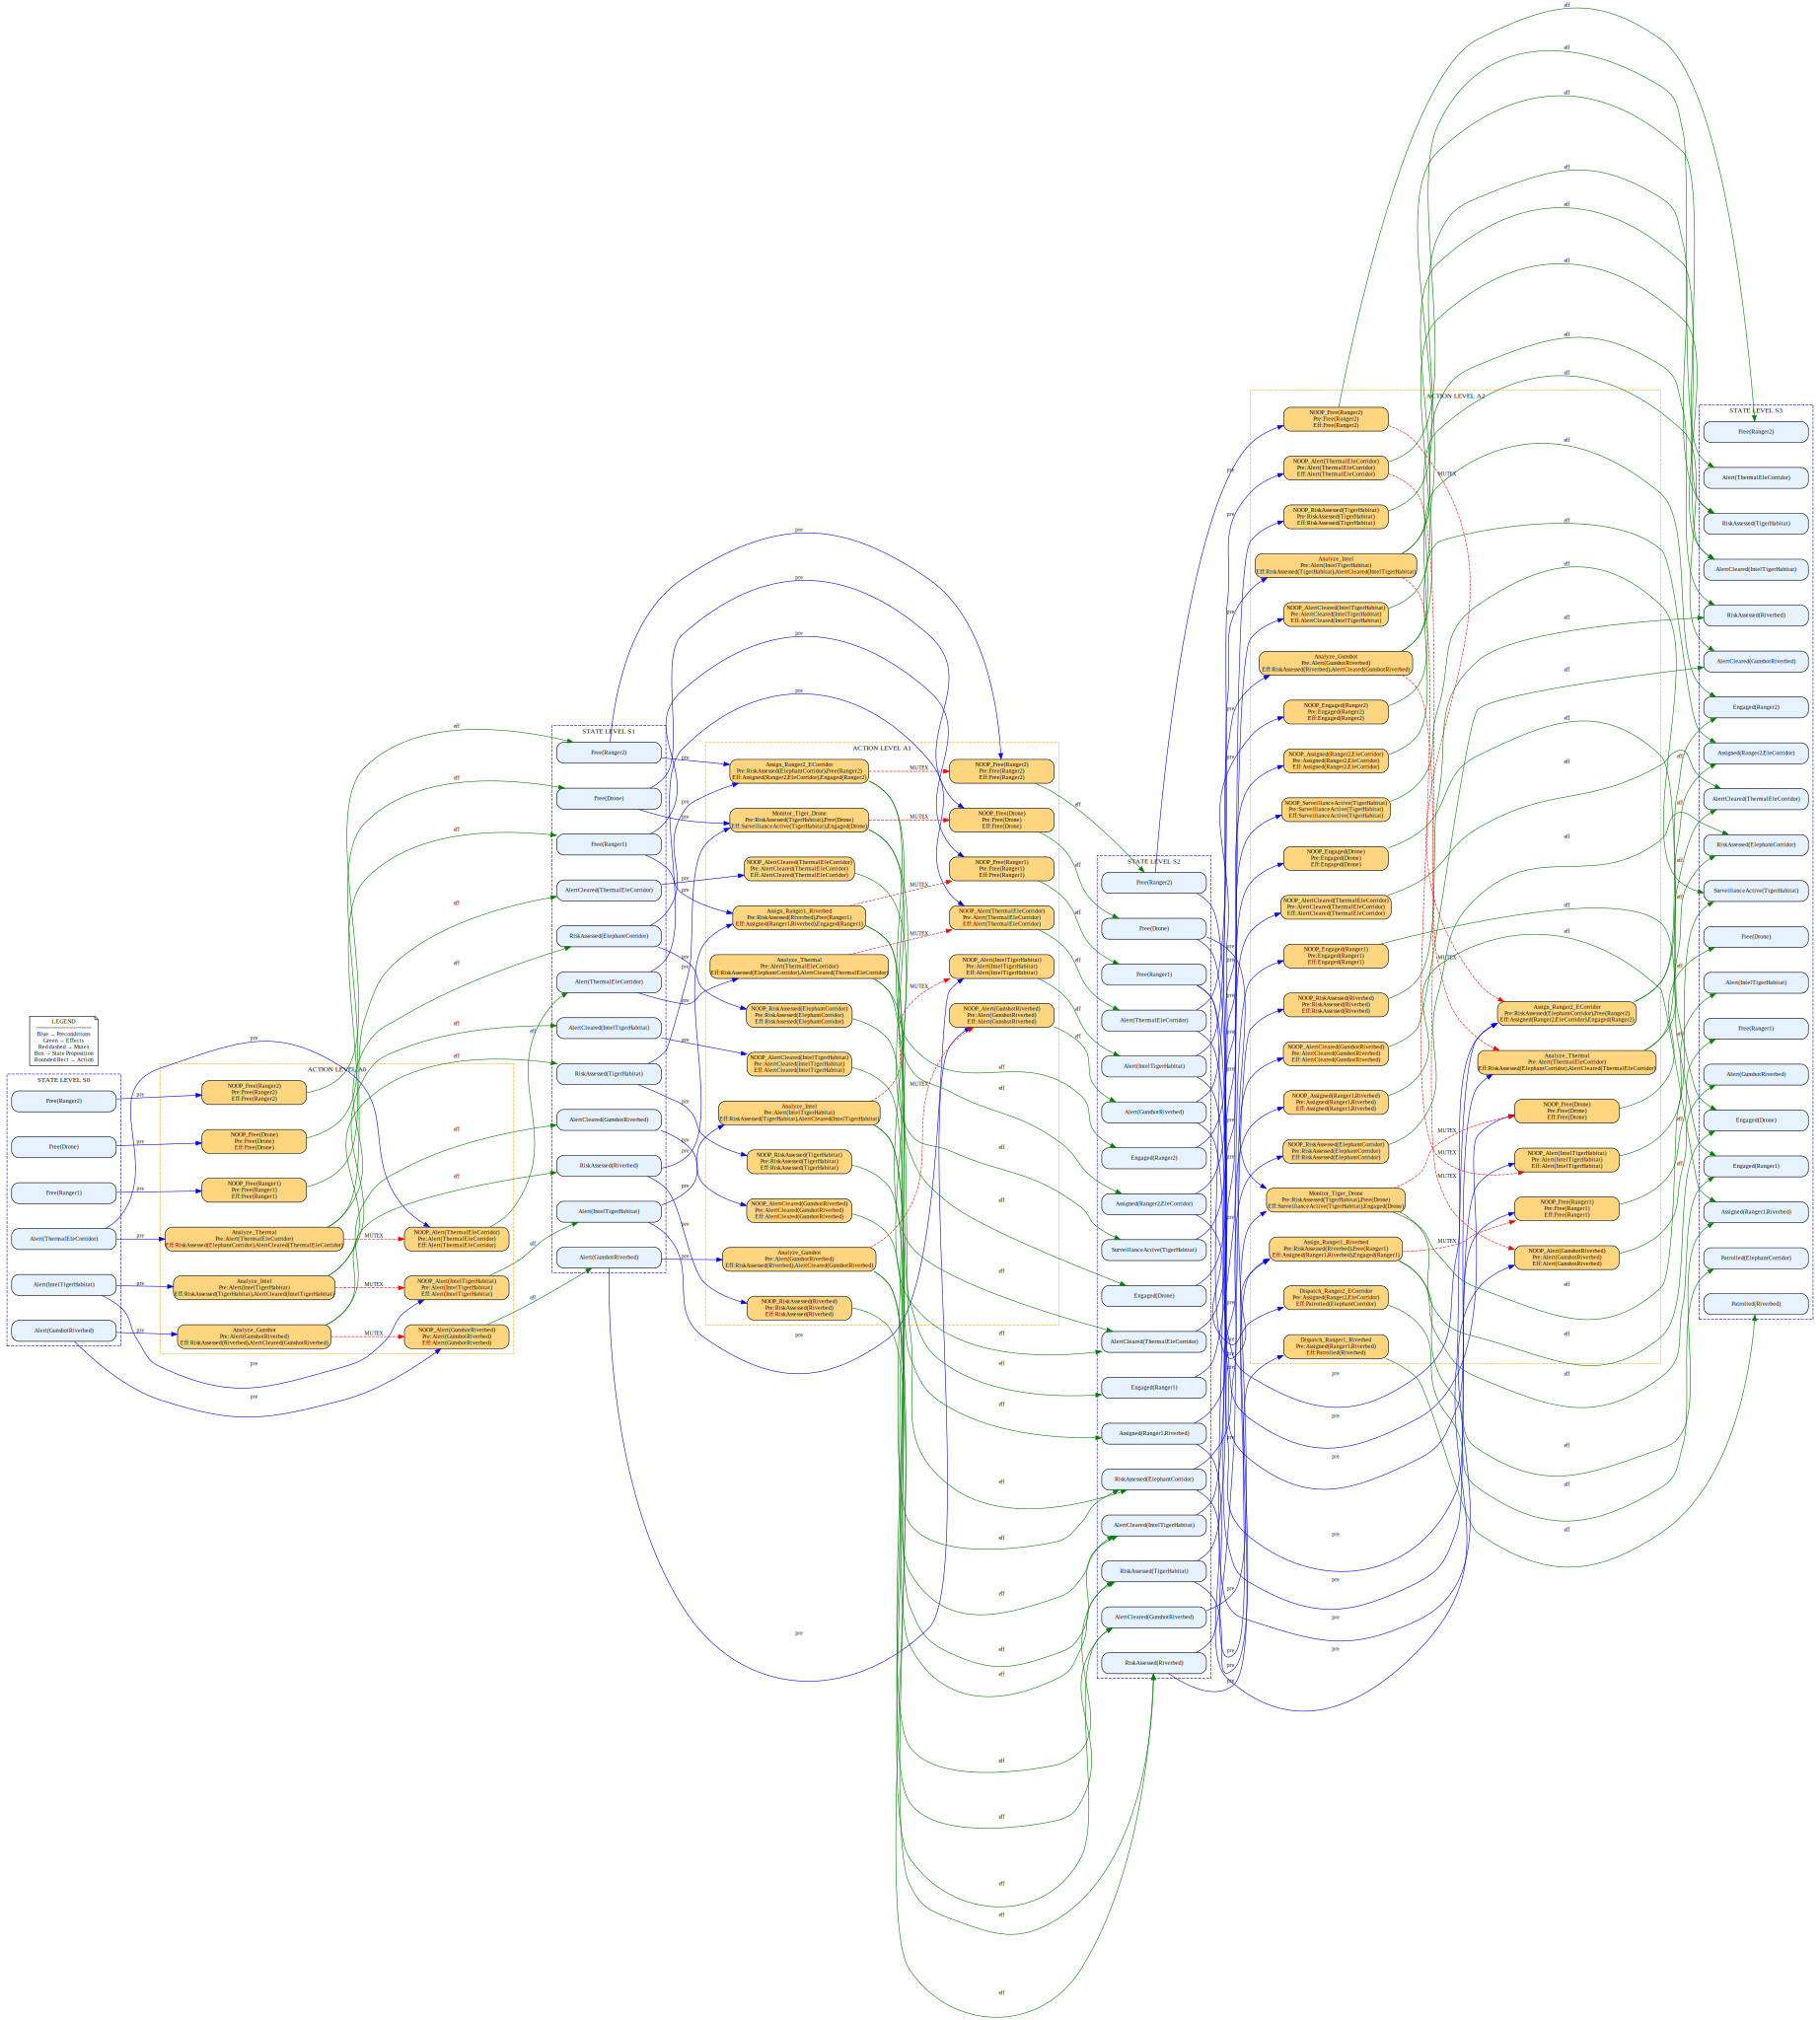

'wildlife_pop_graph.png'

In [10]:
graph = visualize_graphplan_clean(pg, "wildlife_graphplan_clear")
display(graph)
graph.render("wildlife_pop_graph", format="png", cleanup=True)